#### **Use Grid Search to Find the most Informative Peaks**

Import Libraries

In [45]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.signal import peak_widths, peak_prominences
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_validate, GridSearchCV
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score
from Spectra_Preparation_Functions import *

Read the spectral data

In [46]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../../data/current_clean_spectrum.csv", index_col=0)
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [ ]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


In [5]:
#df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: svn_normalise(x))

#### **1 Sample Examples**

In [6]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber     SurID         Status  Absorbance
6206421  210526-3-04   293   400.22778  210526-3  Hyperglycemia   -0.428429
6206422  210526-3-04   294   400.91116  210526-3  Hyperglycemia   -0.426144
6206423  210526-3-04   295   401.59454  210526-3  Hyperglycemia   -0.425297
6206424  210526-3-04   296   402.27789  210526-3  Hyperglycemia   -0.425798
6206425  210526-3-04   297   402.96127  210526-3  Hyperglycemia   -0.427556
...              ...   ...         ...       ...            ...         ...
6208465  210526-3-04  2337  1797.03870  210526-3  Hyperglycemia   -0.744914
6208466  210526-3-04  2338  1797.72200  210526-3  Hyperglycemia   -0.734101
6208467  210526-3-04  2339  1798.40550  210526-3  Hyperglycemia   -0.723319
6208468  210526-3-04  2340  1799.08890  210526-3  Hyperglycemia   -0.712599
6208469  210526-3-04  2341  1799.77220  210526-3  Hyperglycemia   -0.701972

[2049 rows x 6 columns]


Find Peaks Within the spectrum.

In [7]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)
peaks, _ = find_peaks(x=sample['Absorbance'])

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

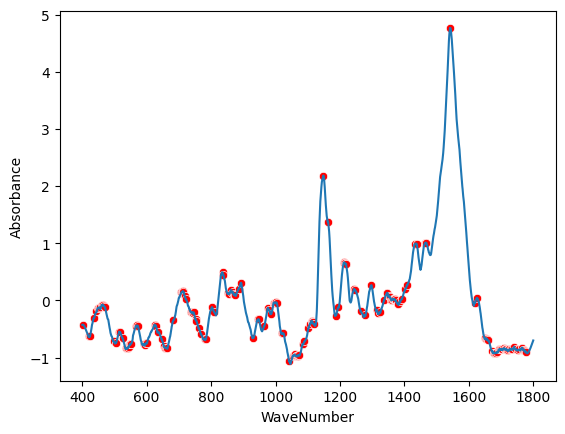

In [8]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peaks], x="WaveNumber", y="Absorbance", color="red")

As you can see, it does not properly find the peaks, so we have to tune the peak finding parameters.

These parameters are based on Thomas Keogh's Search

In [9]:
tuned_peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

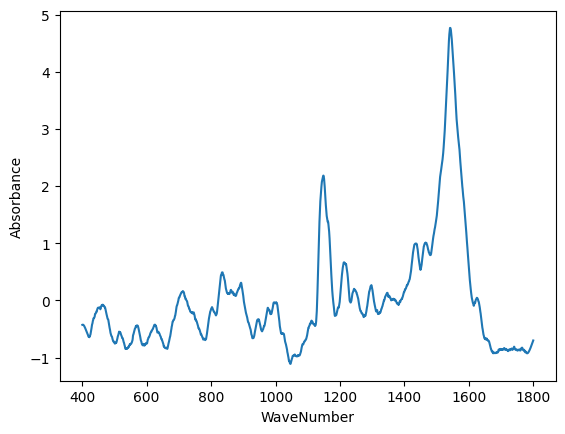

In [10]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[tuned_peaks], x="WaveNumber", y="Absorbance", color="red")

#### **Find the best Peak Finding Parameters**

Create a field for each wavelength.

Train an Extra Trees Classifier

In [11]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [12]:
def evaluate_svm_with_grid_search(df):
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Define the SVM classifier
    svm = SVC(random_state=1234)

    param_grid = {
    'C': [1, 10** 4, 10**6],
    'gamma': ['scale']
    }
    
    # Define the GroupKFold split strategy
    cv = GroupKFold(n_splits=5)

    # Initialise the GridSearchCV object
    grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)

    # Fit the model with the grid search
    # Note: GridSearchCV doesn't directly accept 'groups' as a parameter in 'fit', so we include them in 'cv' splits
    grid_search.fit(X, y, groups=groups)

    # Best parameter set found:
    print(f'Best parameters found: {grid_search.best_params_}')
    
    # Best cross-validation score:
    print(f'Best cross-validation accuracy: {grid_search.best_score_:.4f}')

    # Optionally, you can return the best estimator or the full GridSearchCV object for further inspection or predictions
    return grid_search.best_estimator_

In [13]:
def evaluate_extra_trees_with_grid_search(df):
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Define the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)

    param_grid = {
        'n_estimators': [100, 200, 300],  # Number of trees in the forest
        'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
        'max_depth': [None, 10, 20],  # Maximum depth of the tree
    }
    
    # Define the GroupKFold split strategy
    cv = GroupKFold(n_splits=5)

    # Initialise the GridSearchCV object
    grid_search = GridSearchCV(et, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)

    # Fit the model with the grid search
    grid_search.fit(X, y, groups=groups)

    # Best parameter set found:
    print(f'Best parameters found: {grid_search.best_params_}')
    
    # Best cross-validation score:
    print(f'Best cross-validation accuracy: {grid_search.best_score_:.4f}')

    # Optionally, you can return the best estimator or the full GridSearchCV object for further inspection or predictions
    return grid_search.best_estimator_

#### **1. Using Peak Statistics**

In [14]:
backup = df

In [15]:
statuses = df[['SpecID', 'Status','SurID']].drop_duplicates()

This uses statistical properties of the peaks in each sample to be used as additional features.

In [16]:
peaks = []
widths = []
prominences = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'], distance=10, width=1)


    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

/tmp/ipykernel_2742/272031481.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_2742/272031481.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [17]:
peaks_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
34,201210-1-00,327,423.46240,201210-1,Normal,-0.137193,8.600727,0.074126
47,201210-1-00,340,432.34625,201210-1,Normal,-0.186739,2.888985,0.057276
60,201210-1-00,353,441.23007,201210-1,Normal,-0.145395,8.564034,0.112993
82,201210-1-00,375,456.26425,201210-1,Normal,0.053701,29.697436,0.312350
96,201210-1-00,389,465.83142,201210-1,Normal,0.036478,4.377311,0.083967
...,...,...,...,...,...,...,...,...
6228859,210526-3-49,2241,1731.43510,210526-3,Hyperglycemia,-1.058444,3.624918,0.060653
6228872,210526-3-49,2254,1740.31880,210526-3,Hyperglycemia,-1.223630,2.756891,0.024406
6228890,210526-3-49,2272,1752.61960,210526-3,Hyperglycemia,-1.285067,2.781653,0.072482
6228909,210526-3-49,2291,1765.60360,210526-3,Hyperglycemia,-1.323569,7.387193,0.074082


In [18]:
#sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [19]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [20]:
# # Create a new DataFrame for the summary statistics
# peak_stats = peaks_df.groupby('SpecID').agg({
#     'PeakWidths': ['mean', 'std', 'max', 'min'],
#     'PeakProminences': ['mean', 'std', 'max', 'min']
# }).reset_index()

# # Flatten the multi-level columns and customize the names
# peak_stats.columns = ['SpecID',
#                       'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
#                       'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

Sometimes not every sample has a peak.

In [21]:
peak_stats.head()

,SpecID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
0,201210-1-00,0.027761,1.122750,59,3.682113,-1.578608,17.526858,32.103928,194.114304,1.009065,0.434072,1.006197,4.929611,0.003769
1,201210-1-01,-0.107674,1.132400,53,2.832115,-1.381459,20.232244,33.058101,151.983867,1.022492,0.464389,1.023093,4.082031,0.003311
2,201210-1-02,0.093747,1.279988,46,7.530411,-0.690797,16.977452,18.674036,67.855151,1.074776,0.388680,1.320847,8.195856,0.001621
3,201210-1-03,0.020667,1.253686,38,3.708441,-1.122366,19.193429,21.526621,71.923318,1.014021,0.514524,1.235663,4.660088,0.001049
4,201210-1-04,0.006210,1.017308,57,3.939617,-1.495654,18.315592,33.723261,183.353131,1.024586,0.362103,0.889718,5.373782,0.001595


In [22]:
peak_stats.shape

(3045, 14)

In [23]:
peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(0)

In [24]:
peak_stats.shape

(3045, 15)

In [25]:
peak_stats.head()

,Status,SurID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,
201210-1-00,Normal,201210-1,0.027761,1.122750,59,3.682113,-1.578608,17.526858,32.103928,194.114304,1.009065,0.434072,1.006197,4.929611,0.003769
201210-1-01,Normal,201210-1,-0.107674,1.132400,53,2.832115,-1.381459,20.232244,33.058101,151.983867,1.022492,0.464389,1.023093,4.082031,0.003311
201210-1-02,Normal,201210-1,0.093747,1.279988,46,7.530411,-0.690797,16.977452,18.674036,67.855151,1.074776,0.388680,1.320847,8.195856,0.001621
201210-1-03,Normal,201210-1,0.020667,1.253686,38,3.708441,-1.122366,19.193429,21.526621,71.923318,1.014021,0.514524,1.235663,4.660088,0.001049
201210-1-04,Normal,201210-1,0.006210,1.017308,57,3.939617,-1.495654,18.315592,33.723261,183.353131,1.024586,0.362103,0.889718,5.373782,0.001595


In [26]:
evaluate_extra_trees(peak_stats)

ExtraTreesClassifier Cross-Validation Accuracy: 0.3660 +/- 0.0846


In [27]:
evaluate_extra_trees_with_grid_search(peak_stats)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best parameters found: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100}
Best cross-validation accuracy: 0.3673


ExtraTreesClassifier(criterion='entropy', max_depth=20, random_state=1234)

> ##### **Combine these stats with the full spectra**

In [28]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,-0.141836
1,201210-1-00,294,400.91116,201210-1,Normal,-0.143564
2,201210-1-00,295,401.59454,201210-1,Normal,-0.145366
3,201210-1-00,296,402.27789,201210-1,Normal,-0.147231
4,201210-1-00,297,402.96127,201210-1,Normal,-0.149152
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-1.073592
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-1.047798
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-1.020916
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-0.992939


In [29]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.141836,-0.143564,-0.145366,-0.147231,-0.149152,-0.151119,-0.153125,-0.155160,-0.157217,-0.159286,...,-1.176280,-1.197543,-1.220912,-1.246470,-1.274301,-1.304488,-1.337115,-1.372264,201210-1,Normal
201210-1-01,-0.262623,-0.240687,-0.219481,-0.199000,-0.179239,-0.160193,-0.141858,-0.124228,-0.107301,-0.091070,...,-1.122271,-1.111142,-1.098527,-1.084361,-1.068578,-1.051115,-1.031906,-1.010888,201210-1,Normal
201210-1-02,0.085221,0.063997,0.044915,0.027885,0.012819,-0.000372,-0.011778,-0.021488,-0.029591,-0.036175,...,-0.665229,-0.664763,-0.664042,-0.663061,-0.661816,-0.660302,-0.658515,-0.656449,201210-1,Normal
201210-1-03,-0.072725,-0.075617,-0.078682,-0.081895,-0.085230,-0.088662,-0.092166,-0.095717,-0.099290,-0.102858,...,-0.940238,-0.938131,-0.935871,-0.933462,-0.930912,-0.928226,-0.925409,-0.922467,201210-1,Normal
201210-1-04,0.654952,0.567324,0.486835,0.413239,0.346293,0.285753,0.231374,0.182912,0.140123,0.102763,...,-1.432306,-1.433369,-1.433990,-1.434166,-1.433892,-1.433164,-1.431980,-1.430335,201210-1,Normal


In [30]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5963 +/- 0.0919


In [31]:
evaluate_extra_trees_with_grid_search(wavelength_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
Best cross-validation accuracy: 0.6140


ExtraTreesClassifier(max_depth=20, random_state=1234)

In [32]:
stats_and_spectrum = wavelength_df.merge(peak_stats.drop(columns=['SurID', 'Status']), on='SpecID')
stats_and_spectrum.columns = stats_and_spectrum.columns.astype(str)
stats_and_spectrum.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.141836,-0.143564,-0.145366,-0.147231,-0.149152,-0.151119,-0.153125,-0.155160,-0.157217,-0.159286,...,3.682113,-1.578608,17.526858,32.103928,194.114304,1.009065,0.434072,1.006197,4.929611,0.003769
201210-1-01,-0.262623,-0.240687,-0.219481,-0.199000,-0.179239,-0.160193,-0.141858,-0.124228,-0.107301,-0.091070,...,2.832115,-1.381459,20.232244,33.058101,151.983867,1.022492,0.464389,1.023093,4.082031,0.003311
201210-1-02,0.085221,0.063997,0.044915,0.027885,0.012819,-0.000372,-0.011778,-0.021488,-0.029591,-0.036175,...,7.530411,-0.690797,16.977452,18.674036,67.855151,1.074776,0.388680,1.320847,8.195856,0.001621
201210-1-03,-0.072725,-0.075617,-0.078682,-0.081895,-0.085230,-0.088662,-0.092166,-0.095717,-0.099290,-0.102858,...,3.708441,-1.122366,19.193429,21.526621,71.923318,1.014021,0.514524,1.235663,4.660088,0.001049
201210-1-04,0.654952,0.567324,0.486835,0.413239,0.346293,0.285753,0.231374,0.182912,0.140123,0.102763,...,3.939617,-1.495654,18.315592,33.723261,183.353131,1.024586,0.362103,0.889718,5.373782,0.001595


In [33]:
evaluate_extra_trees(stats_and_spectrum)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5902 +/- 0.0887


In [34]:
evaluate_extra_trees_with_grid_search(stats_and_spectrum)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300}
Best cross-validation accuracy: 0.6121


ExtraTreesClassifier(criterion='entropy', n_estimators=300, random_state=1234)

#### **2. Creating a uniform Peak Featureset**

This aims to create a featureset using peaks within wavenumber intervals.

Assign Peaks to bins of a fixed wavelength interval.

In [35]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

In [36]:
# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_2742/3718610318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [37]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
34,201210-1-00,327,423.46240,201210-1,Normal,-0.137193,8.600727,0.074126,400-425
47,201210-1-00,340,432.34625,201210-1,Normal,-0.186739,2.888985,0.057276,425-450
60,201210-1-00,353,441.23007,201210-1,Normal,-0.145395,8.564034,0.112993,425-450
82,201210-1-00,375,456.26425,201210-1,Normal,0.053701,29.697436,0.312350,450-475
96,201210-1-00,389,465.83142,201210-1,Normal,0.036478,4.377311,0.083967,450-475


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to 0.
If multiple peaks appear their properties are aggregated.

In [38]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status', 'SurID']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with 0
peak_bins.fillna(0, inplace=True)

In [39]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status,SurID
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.702489,0.734378,0.720989,0.000000,-0.612814,-0.295177,-0.513875,-1.058925,-1.225382,-0.008866,...,16.714187,0.000000,15.573611,119.577556,0.000000,2.131577,0.000000,0.000000,Normal,201210-1
201210-1-01,1.005701,0.000000,0.241670,0.000000,0.000000,-0.441145,-0.441078,-0.770078,-1.273313,-1.085052,...,1.155223,0.000000,13.112880,0.000000,143.050278,17.800870,0.000000,0.000000,Normal,201210-1
201210-1-02,0.449341,0.576333,0.000000,0.000000,0.000000,-0.121328,0.000000,-0.582721,-0.487838,-0.473371,...,3.840262,0.000000,4.381959,0.000000,35.976770,0.000000,16.240938,0.000000,Normal,201210-1
201210-1-03,0.000000,0.000000,0.206172,0.000000,0.000000,0.000000,2.077822,0.000000,0.000000,-0.498136,...,0.000000,2.934952,0.000000,0.000000,70.641586,0.000000,57.105582,1.527180,Normal,201210-1
201210-1-04,0.422955,-0.364674,-0.433601,-0.923303,-0.998837,-0.484927,-0.311500,0.055893,-0.771671,-0.931325,...,0.000000,0.000000,135.588036,6.032436,10.272983,2.537245,0.000000,1.830816,Normal,201210-1


In [40]:
evaluate_extra_trees(peak_bins)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5094 +/- 0.1149


In [41]:
evaluate_extra_trees_with_grid_search(peak_bins)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300}
Best cross-validation accuracy: 0.5513


ExtraTreesClassifier(criterion='entropy', n_estimators=300, random_state=1234)

In [42]:
bins_and_spectrum = wavelength_df.merge(peak_stats.drop(columns=['SurID', 'Status']), on='SpecID')
bins_and_spectrum.columns = stats_and_spectrum.columns.astype(str)
bins_and_spectrum.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.141836,-0.143564,-0.145366,-0.147231,-0.149152,-0.151119,-0.153125,-0.155160,-0.157217,-0.159286,...,3.682113,-1.578608,17.526858,32.103928,194.114304,1.009065,0.434072,1.006197,4.929611,0.003769
201210-1-01,-0.262623,-0.240687,-0.219481,-0.199000,-0.179239,-0.160193,-0.141858,-0.124228,-0.107301,-0.091070,...,2.832115,-1.381459,20.232244,33.058101,151.983867,1.022492,0.464389,1.023093,4.082031,0.003311
201210-1-02,0.085221,0.063997,0.044915,0.027885,0.012819,-0.000372,-0.011778,-0.021488,-0.029591,-0.036175,...,7.530411,-0.690797,16.977452,18.674036,67.855151,1.074776,0.388680,1.320847,8.195856,0.001621
201210-1-03,-0.072725,-0.075617,-0.078682,-0.081895,-0.085230,-0.088662,-0.092166,-0.095717,-0.099290,-0.102858,...,3.708441,-1.122366,19.193429,21.526621,71.923318,1.014021,0.514524,1.235663,4.660088,0.001049
201210-1-04,0.654952,0.567324,0.486835,0.413239,0.346293,0.285753,0.231374,0.182912,0.140123,0.102763,...,3.939617,-1.495654,18.315592,33.723261,183.353131,1.024586,0.362103,0.889718,5.373782,0.001595


In [43]:
evaluate_extra_trees(bins_and_spectrum)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5902 +/- 0.0887


In [44]:
evaluate_extra_trees_with_grid_search(bins_and_spectrum)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300}
Best cross-validation accuracy: 0.6121


ExtraTreesClassifier(criterion='entropy', n_estimators=300, random_state=1234)